# Lifetime Analysis (temperature-dependent analysis)


#### Code by: Mattias Juhl, Robert Dumbrell, Johannes Seif

***Note:*** The purpose of this jupyter notebook is to load and analyse data from the Front Detection PL setup. 

HOW TO USE IT
Note that the data has to be stored in a specific structure. In the parent directory of the analysis folder you should create a folder with all the samples as subfolders. That's where you store the data. In the "data" folder you can create a folder called "_analyzed-data" in which you will store the exported parameters from the cropping, binning and Ai+Fs adjustments.

The filenames need to be in a specific format in order to extract relevant information as for instance the temperature. Therefore the user should stick to the following format:

>[Samples name]\_<br>
>[Ref gain, e.g. R3]\_<br>
>[Sample gain, e.g. S6]\_<br>
>[Laser pulse duration, e.g. 0.008s]\_<br>
>[Laser voltage, e.g. 5.0V]\_<br>
>[Beam size, e.g. NB or BB]\_<br>
>[Temperature in °C, e.g. T025]\_<br>
>[Raw_Data.dat]\<br>

1) Select the first block (Preamble with "import..." statements) and press "Shift"+"Enter". This will execute the code inside the block.

2) Do this for all the blocks. If you get a drop-down menue select e.g. the data folder or the files you want to analyse.

3) Execute the "Crop and Bin" block and immediately afterwards the "Plot lifetime" block. In the latter, besides cropping and binning the data, the user can apply the calibrations (Ai and Fs). The Fs values are hard-coded in the code and should be measured before using this notebook (check out ***Calibration_Fs_calc_v1.0.ipynb***). The Ai values on the other hand can be obtained automatically by pressing the "Find Ai values" button. ***NOTE:*** The user is advised to check graphically if the automatically found Ai values make sense.

4) Adjust the Ai (and maybe also Fs) so that all the measurements fit.

5) EXPORT the parameters by clicking on the button.

6) Export the data for import in your preferred data treatment software.

## Preamble

***Note:*** All the required packages are imported here.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from glob import glob
from PyQt5.QtWidgets import QFileDialog, QApplication
import voltage_measurement as vm
import meas_config as mconfig
# import DataPlot
import FindAi as fai
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, HBox, IntProgress
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')
#import pandas as pd
import sys
import time
import errno

## Define constants

***Note:*** Definition of some constants.

In [2]:
# Na = 4.7E15 # p-type doping
# Nd = 1 # n-type doping
# W = 0.0285 # wafer thickness
Na = 1 # p-type doping
Nd = 7.6e14 # n-type doping
W = 0.0180 # wafer thickness
Aivector = np.array([])
gain = np.array([1E5, 1E6, 1E7, 1E])

# Constants for Sinton lifetime analysis
A = 0.0000781786461861564
B = 0.0312360760990958
C = -0.76121
sinton_consts = (A,B,C)

## Get data folders and files

***Note:*** Retrieval of the folder and file names of the data.

In [3]:
# NOTE the main path. is the path where this notebook is saved. The parent folder has to be called analysis
mainpath = os.getcwd()
# NOTE there has to be a folder in the parent folder of the analysis folder that is called 'data'
datapath = os.path.join(os.getcwd().replace('analysis',''),'data')
analyzedpath = os.path.join(os.getcwd().replace('analysis',''),'data','_analyzed-data')

datafolders = [] # list of data folders
datafolders = os.listdir(datapath)
analyzedfolders = os.listdir(analyzedpath)

datafiles = [] # list of list of data files in data folder
dfiles = [] # temporary list of files
analyzedfiles = []
afiles = []
datafiles_paths = []
dfiles_paths = [] # temporary list of file paths
analyzed_paths = []
afiles_paths = []                                                           

for folder in datafolders:
    dfolder = os.path.join(datapath, folder)
    for file in os.listdir(dfolder):
        if file.endswith(".dat"):
            # create a list with all the file names
            dfiles.append(file)
            dfiles_paths.append(os.path.join(dfolder, file))
    
    # append the newly generated list of files and list of file paths to the following lists
    datafiles.append(dfiles)
    datafiles_paths.append(dfiles_paths)
    
    # reset the temporary lists
    dfiles = []
    dfiles_paths = []

for aafolder in analyzedfolders:
    afolder = os.path.join(analyzedpath, aafolder)
    for afile in os.listdir(afolder):
        if afile.endswith("Parameters.txt") or afile.endswith("Parameters_re.txt"):
            afiles.append(afile)
            afiles_paths.append(os.path.join(afolder, afile))
    
    # append the newly generated list of files and list of file paths to the following lists
    analyzedfiles.append(afiles)
    analyzed_paths.append(afiles_paths)
    
    # reset the temporary lists
    afiles = []
    afiles_paths = [] 

## Select data

***Note:*** Select the data folder and then the files you want to analyse.

In [4]:
# Create a dropdown menu to select the data folder that you want to analyse.
SelectDataFolder = widgets.Dropdown(
    options=datafolders,
    description='Select data folder:',
    disabled=False
)
display(SelectDataFolder)

Dropdown(description='Select data folder:', options=('B1-25', 'B1-35', 'B1-45', 'B1-55', 'B1-65', 'B1-75', '_a…

In [5]:
# variable height of the multiselect box
VarHeight = str(len(datafiles[SelectDataFolder.index])*20) + 'px'
# define the multiselect box for the *.dat files in the data folder selected above and display it
DataMultiSelect = widgets.SelectMultiple(
    options=datafiles[SelectDataFolder.index],
    description='Files:',
    disabled=False,
    layout=Layout(width='600px',height=VarHeight)
)
display(DataMultiSelect)

SelectMultiple(description='Files:', layout=Layout(height='140px', width='600px'), options=('B-1_R3_S6_0.008s_…

[OPTIONAL]

***Note:*** Select the folder in which the parameters (exported previously from the lifetime plot) are located. This folder ***has to*** reside within the "data" folder!

In the list select the parameters TXT file that you would like to load later in the lifetime plot.

In [ ]:
# Create a dropdown menu to select the data folder that you want to analyse.
SelectAnalyzedDataFolder = widgets.Dropdown(
    options=analyzedfolders,
    description='Select analyzed data folder:',
    disabled=False
)
display(SelectAnalyzedDataFolder)

In [ ]:
# variable height of the multiselect box
VarHeight = str(len(analyzedfiles[SelectAnalyzedDataFolder.index])*20) + 'px'
# define the multiselect box for the *.dat files in the data folder selected above and display it
AnalyzedDataSelect = widgets.Select(
    options=analyzedfiles[SelectAnalyzedDataFolder.index],
    description='Analyzed files:',
    disabled=False,
    layout=Layout(width='600px',height=VarHeight)
)
display(AnalyzedDataSelect)

## Create list of data objects (Voltage_Measurement)

***Note:*** Import the data and create voltage_measurement (vm) objects containing the data.

In [6]:
# initialize data lists
sel_data_list = [] # list for selected data, voltage measurement objects
sel_dataname_list = [] # list for selected data names
measurement_configs = [] # list for measurement configurations

# collect the data that has been selected by the user in the multiselect box 
# cycle through the selected items in the multiselect box
for i in range(len(DataMultiSelect.index)):
    # read from the data filenames the different parameters
    # Structure needs to be:
    # [Samples name]_[Ref gain]_[Sample gain]_[Laser pulse duration]_[Laser voltage]_[Beam]_[Temp]_Raw_Data
    # A-1 _ R3 _ S6 _ 0.008s _ 5.0V _ NB _ T25 _ Raw_Data
    data_file = datafiles[SelectDataFolder.index][DataMultiSelect.index[i]]
    h = data_file.split('_') # split the file name into the different constituents
    # remove not needed data
    h.remove('Raw')
    h.remove('Data.dat')
    
    # populate the measurement configurations list converting the numbers from string into numbers (int or float)
    # CONVERT the temperature to KELVIN
    measurement_configs.append(
        mconfig.Measurement_Configuration(
            h[0],
            int(h[1].replace('R','')),
            int(h[2].replace('S','')),
            float(h[3].replace('s','')),
            float(h[4].replace('V','')),
            h[5],
            float(h[6].replace('T','')) + 273.15 # temperature in Kelvin
            )
        )
    
    # create a new VM object and append it to the data list
    sel_data_list.append(
        vm.Voltage_Measurement(
            datafiles_paths[SelectDataFolder.index][DataMultiSelect.index[i]],
            W=W,
            Na=Na,
            Nd=Nd,
            T = float(h[6].replace('T','')) + 273.15 # temperature in Kelvin
        )
    )
    sel_dataname_list.append(
        datafiles[SelectDataFolder.index][DataMultiSelect.index[i]]
    )


# Crop and bin the data

***Note:*** Needs to be executed for the rest of the code to run properly... don't know why though. You can crop and bin the data also in the lifetime plots directly (recommended).

In [7]:
# for interactive figures
%matplotlib notebook

# Run the DataPlot class definition
%run DataPlot.py

# prepare the names for the output widgets, i.e. 'out0', 'out1' etc.
output_names = []
output = []
for z in range(len(DataMultiSelect.index)):
    output_names.append('out' + str(z))

# prepare the list of children used in the tab
children_list = str(output_names)
children_list = children_list.replace("'", "")

# create the out0, out1, out2 etc. widgets and a list of the children
for outs in output_names:
    exec("%s = widgets.Output()" % outs)
    exec("output.append(%s)" % outs)

# store the plots of each of the selected data files in a list
Plots = []
for i in range(len(sel_dataname_list)):
    Plots.append(DataPlot(sel_data_list[i], sel_dataname_list[i]))

# populate the tabe with the children, out0, out1, etc.
exec("tab = widgets.Tab(children = %s)" % children_list) 

# set the titles of the tabs
for i in range(len(sel_dataname_list)):
    tab.set_title(i, 'F#' + str(i+1))

# display the tab
display(tab)

# finally put each of the selected data plots in one of the tabs
for i in range(len(sel_dataname_list)):
    code = """with out{0}:
            Plots[{1}].plot_fig()
        """
    exec(code.format(str(i), i))

## Plot lifetimes

***Note:*** This block includes the plotting of the lifetime data with the possibility to individually display the data and apply cropping, binning, A_i and F_s adjustments in one graph.

<IPython.core.display.Javascript object>


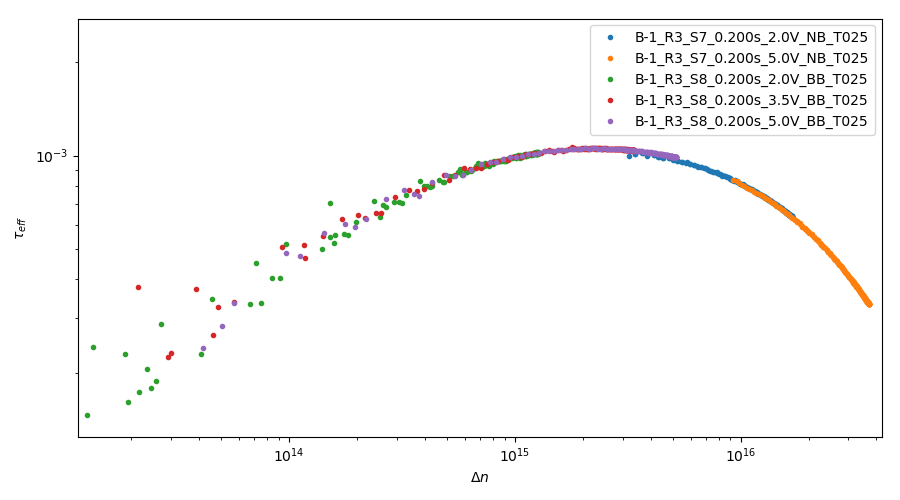

Export DONE!


In [9]:
# for interactive figures
%matplotlib notebook

# Run the DataPlot class definition
# %run DataPlot.py

# set the Fs values for the different beam settings as well as the reflectance of your sample
fs_narrow = 1.30e18 # narrow beam fs
fs_broad = 6.12e16 # broad beam fs
R_810 = 0.05

# define buttons and sliders
for i in range(len(sel_dataname_list)):
        
    # check which beam size was used: BB = broad beam, NB = narrow beam -- > select the Fs value accordingly.
    if '_BB_' in sel_dataname_list[i]:
        fs_value = fs_broad
    else:
        fs_value = fs_narrow
    
    # define the description in front of the Ai and Fs sliders
    Ai_description = r'{}: A_i {:0.2e}'.format(str(i+1), sel_data_list[i].Ai)
    Fs_description = r'{}: F_s {:0.2e}'.format(str(i+1), sel_data_list[i].Fs)
    
    # define code do be executed Ai_values[{1}]
    Ai_Slider = """Ai_slider{0} = widgets.FloatSlider(
            min=14,
            max=20,
            value=16.,
            step=0.005,
            continuous_update=True,
            description=Ai_description,
            layout=Layout(flex='1 1 auto', width='auto')
        )
    """
    Fs_Slider = """Fs_slider{0} = widgets.FloatSlider(
            min=14,
            max=21,
            value=np.log10(fs_value),
            step=0.005,
            continuous_update=True,
            description=Fs_description,
            layout=Layout(flex='1 1 auto', width='auto')
        )
    """
    # define the cropping slider
    crop_slider = """crop{0} = widgets.FloatRangeSlider(
            min=0.,
            max=1.,
            value=[sel_data_list[{1}].crop_start, sel_data_list[{2}].crop_end],
            step=0.01,
            continuous_update=True,
            description='crop range'
        )
    """
    # define the binning slider
    binning_slider = """b{0} = widgets.IntSlider(
            min=1,
            max=100,
            value=5,
            step=1,
            continuous_update=True,
            description='binning'
        )
    """
    
    # display the legend button    
    data_toggle = """data_toggle{} = widgets.ToggleButton(
        value=False,
        description='Data show/hide',
        disabled=False,
        button_style='',
        tooltip='Display data',
        icon='check'
    )
    """
        
    exec(Ai_Slider.format(str(i+1), i))
    exec(Fs_Slider.format(str(i+1)))
    exec(crop_slider.format(str(i+1), i, i))
    exec(binning_slider.format(str(i+1)))
    exec(data_toggle.format(str(i+1)))

# define the legend button    
legend_disp_toggle = widgets.ToggleButton(
    value=True,
    description='Legend',
    disabled=False,
    button_style='',
    tooltip='Display legend',
    icon='check'
)

# Define what happens on clicking the Export button
def export_parameters(b):
    
    # Create the parameter file
    parameter_file_name = os.path.join(analyzedpath, SelectDataFolder.value + '_Parameters.txt')
    
    # Check if the folder exists, if not... create it!
    if not os.path.exists(os.path.dirname(parameter_file_name)):
        try:
            os.makedirs(os.path.dirname(parameter_file_name))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

    with open(parameter_file_name, "w+") as f:
        
        f.write('file name\tAi\tLOG(Ai)\tFs\tLOG(Fs)\tbinn\tcrop_start\tcrop_end\n')

        for i in range(len(sel_dataname_list)):

            # write the parameters to the txt file
            f.write(
                sel_dataname_list[i] + '\t' +
                str('{0:.2f}'.format(sel_data_list[i].Ai)) + '\t' +
                str('{0:.2f}'.format(np.log10(sel_data_list[i].Ai))) + '\t' +
                str('{0:.2f}'.format(sel_data_list[i].Fs)) + '\t' +
                str('{0:.2f}'.format(np.log10(sel_data_list[i].Fs))) + '\t' +
                str('{0:.2f}'.format(sel_data_list[i].binn)) + '\t' +
                str('{0:.2f}'.format(sel_data_list[i].crop_start)) + '\t' +
                str('{0:.2f}'.format(sel_data_list[i].crop_end) + '\n')
            )

        # close the newly created txt file
        print("Export DONE!")
        f.close()

# Define what happens on clicking the Import button
def import_parameters(b):
    
    print("Importing parameters... please wait!")
    # define a parameter array
    parameters = []
    
    # Open the file to read
    f = open(os.path.join(analyzedpath, SelectAnalyzedDataFolder.value, AnalyzedDataSelect.value), "r")
    
    # Load the data from the parameters file
    for i, line in enumerate(f):
        
        if i != 0:
            
            # remove the newline \n, split the line and save everything in parameters
            parameters.append(line.split())
            
    # Read out the data from each set in parameters and apply it to the sliders
    for dataset in parameters:
        
        dataset_name = dataset[0]
        
        for a, select_name in enumerate(DataMultiSelect.value):
            
            if dataset_name == select_name:
                
                Set_Fs = """Fs_slider{}.value = float(dataset[4])"""
                Set_Ai = """Ai_slider{}.value = float(dataset[2])"""
                Set_binn = """b{}.value = int(float(dataset[5]))"""
                start = float(dataset[6])
                end = float(dataset[7].replace('\n',''))
                Set_crop = """crop{}.value = [start, end]"""
                exec(Set_Fs.format(str(a+1)))
                exec(Set_Ai.format(str(a+1)))
                exec(Set_binn.format(str(a+1)))
                exec(Set_crop.format(str(a+1)))
    
    print("Importing DONE!")

# define button to export Ai, Fs, crop and binning values for all loaded data files
export_button = widgets.Button(description="Export parameters")
export_button.on_click(export_parameters)


import_button = widgets.Button(description="Import parameters")
import_button.on_click(import_parameters)

# create the lifetime plot
fig_LT, ax_LT  = plt.subplots(figsize=(9,5), tight_layout=True)

# plot the data
for i in range(len(sel_dataname_list)):
    plot_data = """d{}_line,  = ax_LT.plot(
        sel_data_list[{}].nxc_from_PL(),
        sel_data_list[{}].tau_eff(nxc=sel_data_list[{}].nxc_from_PL()), '.', label = sel_dataname_list[{}][:-13]
        )
        """
    exec(plot_data.format(str(i+1), i, i, i, i))

# define the legend and set it to visible
legend = ax_LT.legend(loc=0)
legend.set_visible(True)

# set the plot to log-log and set the limits and axis labels
plt.loglog()
plt.xlim(1e13,1e17)
plt.ylim(1e-5,1e-2)
plt.xlabel(r'$\Delta n$')
plt.ylabel(r'$\tau_{eff}$')

# change the reflectance data to R_810 for all the measurements
for i in range(len(sel_dataname_list)):
    reflect_data = """sel_data_list[{}].R = R_810"""
    exec(reflect_data.format(i))

# definition of the plot update function
def update_lifetime_plot():

    for i in range(len(sel_dataname_list)):
        # get the Fs values from the sliders and update them in the data object (vm)
        Set_Fs = """sel_data_list[{}].Fs = 10**Fs_slider{}.value"""
        Fs_new_description = r'{}: F_s {:0.2e}'.format(str(i+1), sel_data_list[i].Fs)
        Set_Fs_description = """Fs_slider{}.description = Fs_new_description"""
        exec(Set_Fs.format(i, str(i+1)))
        exec(Set_Fs_description.format(str(i+1)))

        # get the Ai values from the sliders and update them in the data object (vm)
        Set_Ai = """sel_data_list[{}].Ai = 10**Ai_slider{}.value"""
        Ai_new_description = r'{}: A_i {:0.2e}'.format(str(i+1), sel_data_list[i].Ai)
        Set_Ai_description = """Ai_slider{}.description = Ai_new_description"""
        exec(Set_Ai.format(i, str(i+1)))
        exec(Set_Ai_description.format(str(i+1)))

        # get the crop and binning values from the sliders and update them in the data object (vm)
        Set_crop_start = """sel_data_list[{}].crop_start = crop{}.value[0]"""
        Set_crop_end = """sel_data_list[{}].crop_end = crop{}.value[1]"""
        Set_binning = """sel_data_list[{}].binn = b{}.value"""
        exec(Set_crop_start.format(i, str(i+1)))
        exec(Set_crop_end.format(i, str(i+1)))
        exec(Set_binning.format(i, str(i+1)))

        # plot the data with the new set of Fs and Ai
        Plot_line_x = """d{}_line.set_xdata(sel_data_list[{}].nxc_from_PL())"""
        Plot_line_y = """d{}_line.set_ydata(sel_data_list[{}].tau_eff(nxc=sel_data_list[{}].nxc_from_PL()))"""
        exec(Plot_line_x.format(str(i+1), i))
        exec(Plot_line_y.format(str(i+1), i, i))
        
        # toggle the data on or off (show / hide)
        ShowHide = """d{}_line.set_visible(data_toggle{}.value)"""
        exec(ShowHide.format(str(i+1), str(i+1)))
        
    legend.set_visible(legend_disp_toggle.value)
    plt.tight_layout()

# Define what happens on clicking the "Find Ai values" button
def Find_Ai(b):
    
    Ai_Values = []
    print("Calculating Ai values... (PLEASE WAIT!)")
    Ai_Values = fai.Newton_dm(sel_data_list, sel_dataname_list, 0.003, 100)
    
    # diplay progress bar
    max_count = len(sel_data_list)
    progress_bar = IntProgress(min=0, max=max_count)
    print("Updating graph with Ai values...")
    display(progress_bar)
    
    count = 0
    for i in range(len(sel_dataname_list)):
        # get the Ai values from the Ai_values found automatically and update them in the data object (vm)
        sel_data_list[i].Ai = 10**Ai_Values[i]
        Set_Ai = """Ai_slider{}.value = Ai_Values[i]"""
        Ai_new_description = r'{}: A_i {:0.2e}'.format(str(i+1), sel_data_list[i].Ai)
        Set_Ai_description = """Ai_slider{}.description = Ai_new_description"""
        exec(Set_Ai.format(str(i+1), i))
        exec(Set_Ai_description.format(str(i+1)))
        progress_bar.value += 1
        time.sleep(.1)
        count += 1
        
    update_lifetime_plot()
    print("Processing DONE!")

# define button to find Ai automatically
Ai_button = widgets.Button(description="Find Ai values")
Ai_button.on_click(Find_Ai)

# run the plot update function when the Ai or Fs sliders are changed
for i in range(len(sel_dataname_list)):
    
    Ai_on_change = """Ai_slider{}.on_trait_change(update_lifetime_plot, 'value')"""
    Fs_on_change = """Fs_slider{}.on_trait_change(update_lifetime_plot, 'value')"""
    Crop_on_change = """crop{}.on_trait_change(update_lifetime_plot, 'value')"""
    Binn_on_change = """b{}.on_trait_change(update_lifetime_plot, 'value')"""
    DataToggle_on_change = """data_toggle{}.on_trait_change(update_lifetime_plot, 'value')"""
    exec(Ai_on_change.format(str(i+1)))
    exec(Fs_on_change.format(str(i+1)))
    exec(Crop_on_change.format(str(i+1)))
    exec(Binn_on_change.format(str(i+1)))
    exec(DataToggle_on_change.format(str(i+1)))
    
legend_disp_toggle.on_trait_change(update_lifetime_plot, 'value')

# define the box layout
box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='100%')

# define the sliders to show below the graph
for i in range(len(sel_dataname_list)):
    slider_code = """slider_box{} = Box(children=[Ai_slider{}, Fs_slider{}, crop{}, b{}, data_toggle{}], layout=box_layout)"""
    exec(slider_code.format(str(i+1), str(i+1), str(i+1), str(i+1), str(i+1), str(i+1)))

update_lifetime_plot()

# prepare the names for the output widgets, i.e. 'out0', 'out1' etc.
output_names = []
output = []
sliderbox_names = []

# generate the output names and sliderbox names
for z in range(len(DataMultiSelect.index)):
    output_names.append('out' + str(z))

# prepare the list of children used in the tab
children_list = str(output_names)
children_list = children_list.replace("'", "")

# create the out0, out1, out2 etc. widgets and a list of the children
for outs in output_names:
    exec("%s = widgets.Output()" % outs)
    exec("output.append(%s)" % outs)
    
# populate the tabe with the children, out0, out1, etc.
exec("tab = widgets.Tab(children = %s)" % children_list) 

# set the titles of the tabs
for i in range(len(sel_dataname_list)):
    tab.set_title(i, 'F#' + str(i+1))

# display the tab
display(tab)
items = [legend_disp_toggle, export_button, import_button, Ai_button]
box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')
box_auto = Box(children=items, layout=box_layout)
display(VBox([box_auto]))

# display(legend_disp_toggle)
# display(export_button)
# display(import_button)
# display(Ai_button)

# finally put each of the selected data plots in one of the tabs
for i in range(len(sel_dataname_list)):
    code = """with out{0}:
            display(slider_box{1})
        """
    exec(code.format(str(i), str(i+1)))


### Save data

***Note:*** Below, the user selects the data files to be stored in a *.txt file. Note that it is not the initial data that is saved, but the one which is cropped and binned as well as calibrated (A_i, F_s).

In [10]:
# variable height of the multiselect box
VarHeight = str(len(datafiles[SelectDataFolder.index])*20) + 'px'
# define the multiselect box for the *.dat files in the data folder selected above and display it
DataMultiSelectSave = widgets.SelectMultiple(
    options=datafiles[SelectDataFolder.index],
    description='Files:',
    disabled=False,
    layout=Layout(width='600px',height=VarHeight)
)
display(DataMultiSelectSave)

SaveCheckbox = widgets.Checkbox(
    value=False,
    description='Save data?',
    disabled=False
)
display(SaveCheckbox)

name_split = sel_dataname_list[0].split("_")
name_split.pop(len(name_split)-1)
name_split.pop(len(name_split)-1)

save_name = widgets.Text(
    value=name_split[0],
    placeholder='Type something',
    description='File name:',
    disabled=False
)
display(save_name)

SelectMultiple(description='Files:', layout=Layout(height='140px', width='600px'), options=('B-1_R3_S6_0.008s_…

Checkbox(value=False, description='Save data?')

Text(value='B-1', description='File name:', placeholder='Type something')

***Note:*** Below the data is saved into a *.txt file with the "File name" as name.

B-1_R3_S7_0.200s_2.0V_NB_T025_Raw_Data.dat
B-1_R3_S7_0.200s_5.0V_NB_T025_Raw_Data.dat
B-1_R3_S8_0.200s_2.0V_BB_T025_Raw_Data.dat
B-1_R3_S8_0.200s_3.5V_BB_T025_Raw_Data.dat
B-1_R3_S8_0.200s_5.0V_BB_T025_Raw_Data.dat


<IPython.core.display.Javascript object>


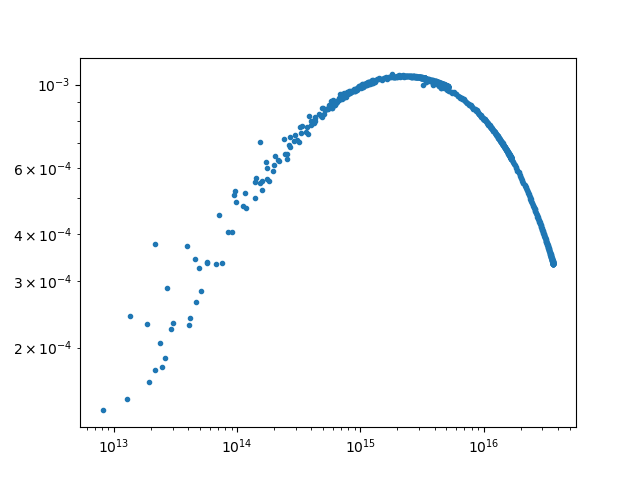

In [11]:
for i in range(len(DataMultiSelect.index)):
    
    # cycle through all the loaded data files (the selected one at the top of this code).
    # check if the name exists in the ones the user selected to save.
    # if it does, save the data, else skip that file - break
    if sel_dataname_list[i] in DataMultiSelectSave.value:
        # print the names of the data files that were used
        print(sel_dataname_list[i])
    
        # Concatentate the lifetime data into one data structure
        if i == 0:
            col_stack_data = """LT_dat = np.column_stack((
                sel_data_list[{}].nxc_from_PL(),
                sel_data_list[{}].tau_eff(nxc=sel_data_list[{}].nxc_from_PL())
                ))
                """
            exec(col_stack_data.format(i, i, i))
            LT_dat.shape
        else:
            v_stack_data = """LT_dat = np.vstack((
                LT_dat,
                np.column_stack((sel_data_list[{}].nxc_from_PL(), sel_data_list[{}].tau_eff(nxc=sel_data_list[{}].nxc_from_PL())))
                ))
                """
            exec(v_stack_data.format(i, i, i))
            LT_dat.shape

# Plot it to check
fig_check, ax_check  = plt.subplots()
ax_check.plot(LT_dat[:,0], LT_dat[:,1], '.')
# plt.plot(d_2.nxc_from_PL(), d_2.tau_eff(nxc=d_2.nxc_from_PL()))
plt.loglog()
# plt.ylim(-3e-4,6e-3)
plt.show()

# Save the data to a txt file if the checkbox was checked
if SaveCheckbox:

    # Save the compiled data
    fname = save_name.value + '.txt'
    np.savetxt(os.path.join(analyzedpath,fname), LT_dat, header='nxc\ttau', delimiter='\t')

# Add the file names of the files selected to save to the end of txt files 
f = open(fname, 'a+')
f.write('\n')
for i in range(len(DataMultiSelectSave.value)):
    
    f.write(DataMultiSelectSave.value[i] + '\n')
    
f.close()